In [1]:
# !pip install qiskit==1.0.1 qiskit-aer==0.14.2 qiskit-algorithms==0.3.0 qiskit-machine-learning==0.7.2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
%matplotlib inline

In [3]:
backend = AerSimulator()

In [4]:
import math

# Function to normalize data for quantum state preparation
def normalize_data(data):
    # Compute the norm (Euclidean norm)
    norm = math.sqrt(sum(x**2 for x in data))
    
    # Normalize the data
    normalized_data = [x / norm for x in data] if norm != 0 else data
    
    return normalized_data


In [5]:
import numpy as np

# Quantum State Preparation for Data Points and Centroids
def quantum_state_prep(qc, qr, data):
    data = normalize_data(data)  # Normalize the data
    for i, d in enumerate(data):
        # Calculate the angle theta based on the normalized data
        theta = 2 * np.arccos(d)  # Angle for the rotation
        
        # Apply the rotation gate RY(theta) on the i-th qubit
        qc.ry(theta, qr[i])  # Apply the RY gate to qubit qr[i] with angle 'theta'


In [6]:
def swap_test(data_point, centroid):
    global print_circuit_once 
    # Create a quantum circuit with ancilla and two quantum registers
    ancilla = QuantumRegister(1, 'ancilla') #one qubit
    qr_x = QuantumRegister(len(data_point), 'x') #len(data_point) is the numer of qubit and x is the nzame given to the qubit
    qr_y = QuantumRegister(len(data_point), 'y')
    cr = ClassicalRegister(1, 'result') #stores classical bits
    # TODO: Create a Quantum Circuit qc with all the registers defined above.
    qc = QuantumCircuit(ancilla,qr_x,qr_y,cr)


    
    
    # Prepare the state |x⟩ and |y⟩
    quantum_state_prep(qc, qr_x, data_point)
    quantum_state_prep(qc, qr_y, centroid)
    
    #TODO: Apply Hadamard gate to the ancilla
    qc.h(ancilla[0])
    
    
    # TODO: Apply controlled-SWAP gates between corresponding qubits of the data point and centroid
    for i in range(len(data_point)):
      qc.cswap(ancilla[0],qr_x[i],qr_y[i])
      pass
    
    #TODO: Apply another Hadamard gate to the ancilla
    qc.h(ancilla[0])
    
    
    # Measure the ancilla
    qc.measure(ancilla, cr)

    if not print_circuit_once:
        qc.draw(output='mpl')
        print_circuit_once = True 
    
    # Simulate the circuit
    transpiled_qc = transpile(qc, backend)
    result = backend.run(transpiled_qc, shots=1024).result()
    counts = result.get_counts()
    
    # Probability of measuring 0 in the ancilla
    p0 = counts.get('0', 0) / 1024

     # TODO: Calculate the inner product estimate from the measurement results
    inner_product = (2*p0-1) # 
    return inner_product


In [7]:
import numpy as np

# Quantum Distance Estimation using the formula for squared Euclidean distance
def quantum_distance(data_point, centroid):
    # Classical scalar |x| and |y|
    norm_x = np.linalg.norm(data_point)  
    norm_y = np.linalg.norm(centroid)    
    
    # Quantum estimation of <x|y> using swap test
    inner_product = swap_test(data_point, centroid)
    
    # Compute the squared Euclidean distance
    distance_squared = norm_x**2 + norm_y**2 - 2 * inner_product
    
    # Return the distance (taking the square root of the squared distance)
    distance = np.sqrt(distance_squared)
    
    return distance


In [8]:
import numpy as np

# Update centroids based on assigned clusters
def update_centroids(clusters, data):
    new_centroids = []
    for cluster in clusters:
        if len(cluster) > 0:
            # Compute the mean of the cluster
            centroid = np.mean([data[i] for i in cluster], axis=0)
        else:
            # Handle empty clusters: Choose a random data point as the centroid
            centroid = data[np.random.randint(0, len(data))]
        
        new_centroids.append(centroid)
    return new_centroids


In [9]:
# # Visualization function for plotting points and centroids in 2D
# def visualize_clusters(data, centroids, clusters, iteration):
#     colors = ['r', 'g', 'b', 'y', 'c', 'm']

#     plt.figure()

#     for i, cluster in enumerate(clusters):
#         cluster_points = np.array([data[j] for j in cluster])
#         plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')

#     # Plot centroids
#     centroids = np.array(centroids)
#     plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

#     plt.title(f'Iteration {iteration}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.legend()
#     plt.grid(True)
#     plt.show()

def visualize_clusters(data, centroids, clusters, iteration):
    colors = ['r', 'g', 'b', 'y', 'c', 'm']

    plt.figure()

    for i, cluster in enumerate(clusters):
        cluster_points = np.array([data[j] for j in cluster])
        
        # Check if cluster_points is 2D
        print(f"Cluster {i+1} shape: {cluster_points.shape}")
        
        # If cluster_points is 2D, proceed to plot
        if cluster_points.ndim == 2:
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], label=f'Cluster {i+1}')
        else:
            print(f"Warning: Cluster {i+1} is not 2D, skipping plotting.")
    
    # Plot centroids
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=100, label='Centroids')

    plt.title(f'Iteration {iteration}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()


In [10]:
# Quantum K-means Algorithm with 2D visualization
def quantum_kmeans(data, k, max_iters=100):
    # Initialize random centroids
    centroids = data[np.random.choice(len(data), k, replace=False)]

    for iteration in range(max_iters):
        clusters = [[] for _ in range(k)]

        # Assign each point to the nearest centroid
        for i, point in enumerate(data):
            distances = [quantum_distance(point, centroid) for centroid in centroids]
            cluster_idx = np.argmin(distances)
            clusters[cluster_idx].append(i)

        # Visualize clusters and centroids in 2D
        visualize_clusters(data, centroids, clusters, iteration)

        # Update centroids
        new_centroids = update_centroids(clusters, data)

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return clusters, centroids

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


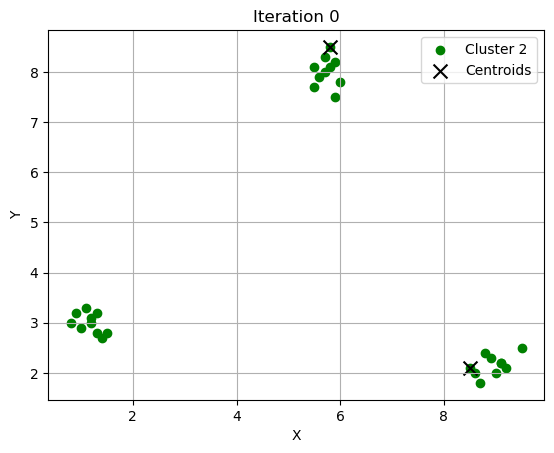

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


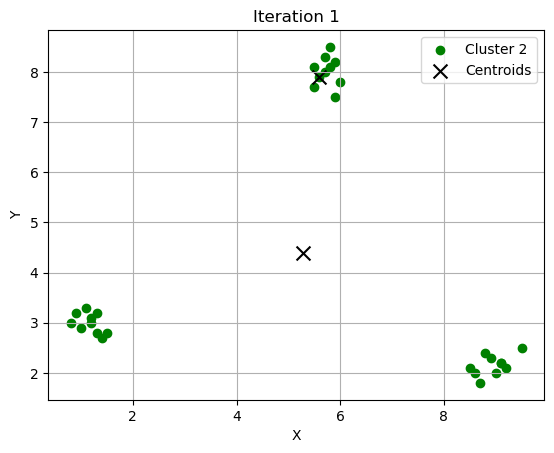

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


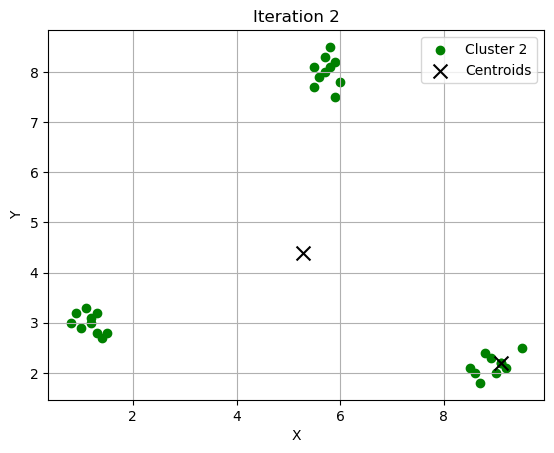

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


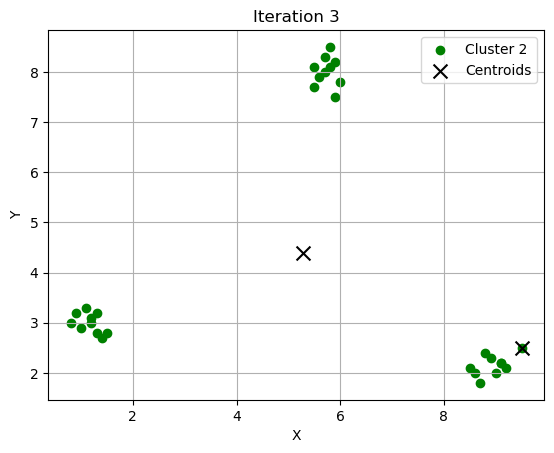

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


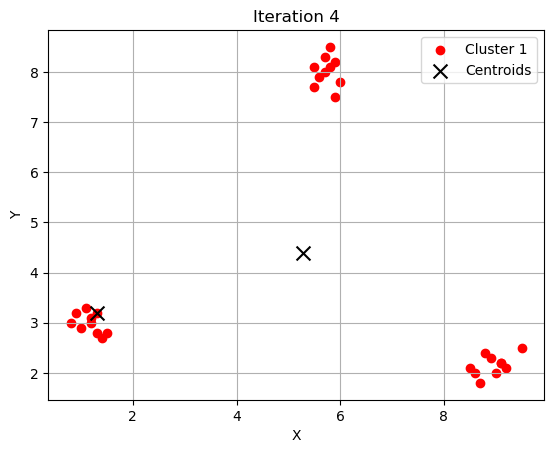

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


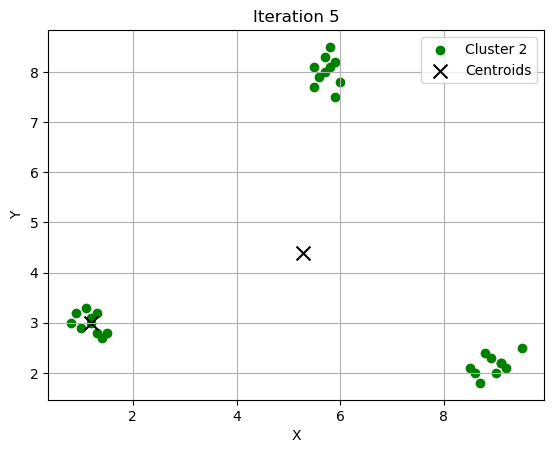

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


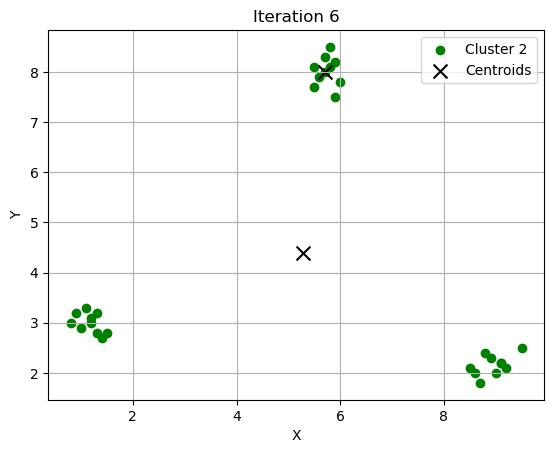

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


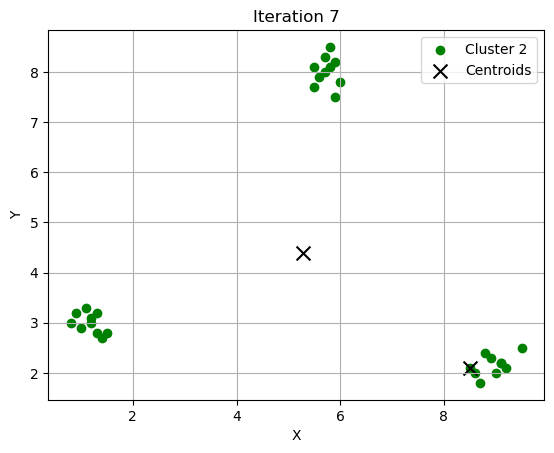

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


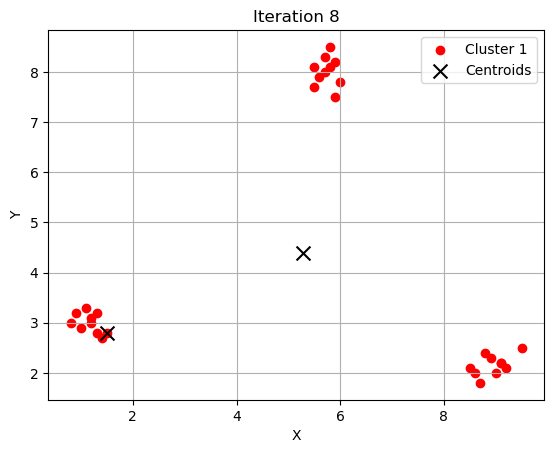

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


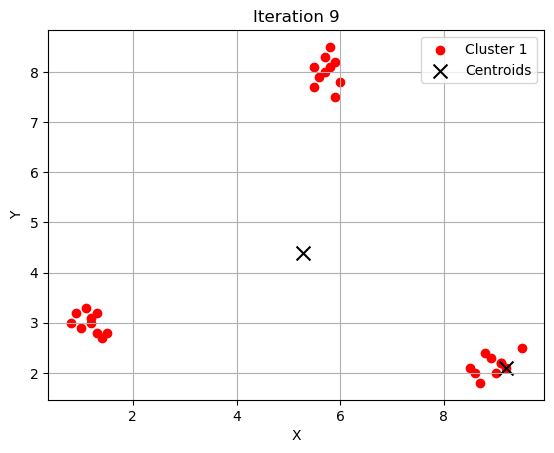

Cluster 1 shape: (0,)
Cluster 2 shape: (30, 2)


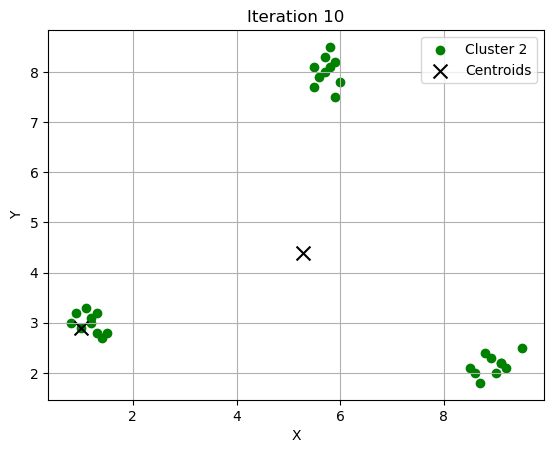

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


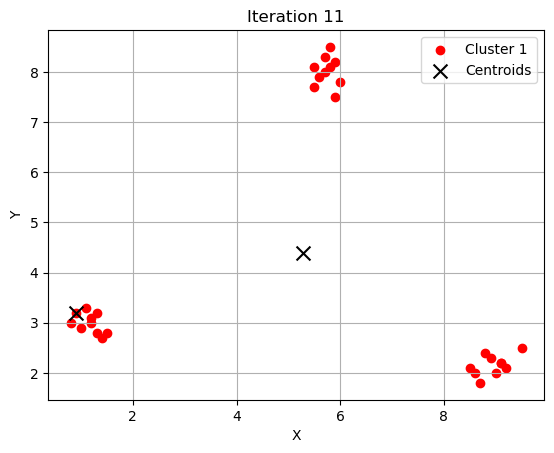

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


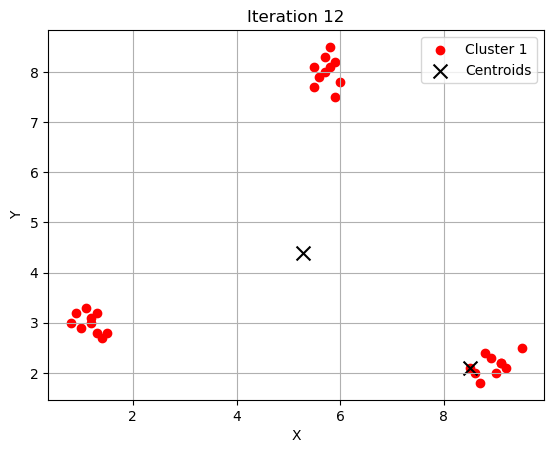

Cluster 1 shape: (30, 2)
Cluster 2 shape: (0,)


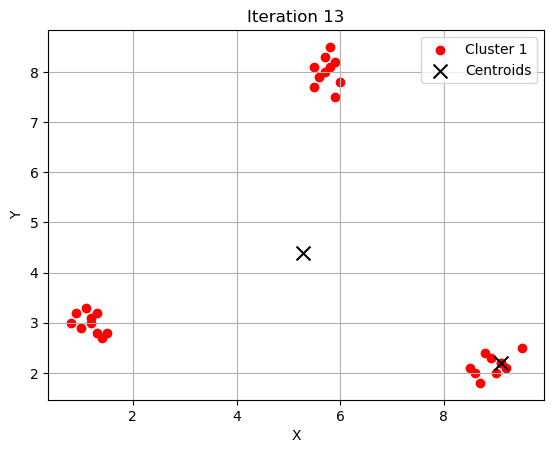

Final Cluster 1 assignments: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Final Cluster 1 Centroids: [5.28333333 4.39      ]


Final Cluster 2 assignments: []
Final Cluster 2 Centroids: [9.1 2.2]




In [11]:
if __name__ == "__main__":
    print_circuit_once = True
    # Sample 3D data
    data = np.array([
    [1.2, 3.1], [1.5, 2.8], [0.8, 3.0], [5.5, 8.1], [6.0, 7.8],
    [5.8, 8.5], [9.1, 2.2], [8.7, 1.8], [9.5, 2.5], [1.3, 3.2],
    [1.0, 2.9], [5.7, 8.0], [5.9, 7.5], [9.0, 2.0], [8.5, 2.1],
    [1.1, 3.3], [1.4, 2.7], [0.9, 3.2], [5.6, 7.9], [5.7, 8.3],
    [8.9, 2.3], [9.2, 2.1], [8.8, 2.4], [1.2, 3.0], [1.3, 2.8],
    [5.9, 8.2], [5.5, 7.7], [9.1, 2.2], [8.6, 2.0], [5.8, 8.1]
])

    # Run Quantum K-means with k=2 clusters
    k = 2
    clusters, centroids = quantum_kmeans(data, k)

    for i in range(k):
        print("Final Cluster",i+1,"assignments:", clusters[i])
        print("Final Cluster",i+1,"Centroids:", centroids[i])
        print("\n")
